In [1]:
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
import math
import logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(asctime)s: %(message)s')

# %matplotlib widget
%matplotlib inline

import ipywidgets as widgets

%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

### Signal to Noise ratio (SnR)

### calculated with: $ (\frac{rms(signal)}{rms(noise)})^2 $ and often displayed in decibels: $ 20\log_{10}(\frac{rms(signal)}{rms(noise)}) $

### rms = root mean square: $ \sqrt{\frac{1}{n}\sum_{i=1}^{n} x^{2}} $

In [4]:
def rms(s):
    return np.sqrt(np.mean(s**2)) ### this function should return the root mean square of s

def interactive_plot_SnR(sig_multiplier, sigma):
    samp = 1000
    noise = np.random.normal(scale=sigma,size=samp)
    signal = np.sin(np.arange(0,1,1/samp)*2*np.pi)*sig_multiplier
    fig, ax = plt.subplots(figsize=(12,4), nrows=1, ncols=3, sharey=True)
    __ = ax[0]. set_ylim([-10,10])
    ax[0].plot(signal)
    ax[1].plot(noise)
    ax[2].plot(signal+noise)

    rms_signal, rms_noise = rms(signal), rms(noise)
    print(f'RMS: signal {rms_signal:.2f} noise {rms_noise:.2f}')
    snr = rms_signal / rms_noise
    print(f'SNR: {snr**2:.2f}')
    print(f'or {20*np.log10(snr):.2f}dB')


_ = widgets.interact(interactive_plot_SnR, sig_multiplier=(0.5,5,0.5), sigma=(0.2,3.,0.2))


# complete the rms function before running

interactive(children=(FloatSlider(value=2.5, description='sig_multiplier', max=5.0, min=0.5, step=0.5), FloatS…

### Tuning curves

In [6]:
# generate data:
samp = 1000
rate = np.array([5,5,6,8,11,15,20,22,20,15,11,8,6,5,5]) / samp
angles = np.arange(10,160,10)
duration = 5

time_array = np.arange(0, duration, 1/samp)
spk_mat = []
for r in rate:
    spk_array = (np.random.uniform(size=samp*duration)<r).astype(np.int32)
    spk_mat.append(spk_array)

spk_mat = np.asarray(spk_mat)
spk_mat

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [7]:
spk_mat.shape

(15, 5000)

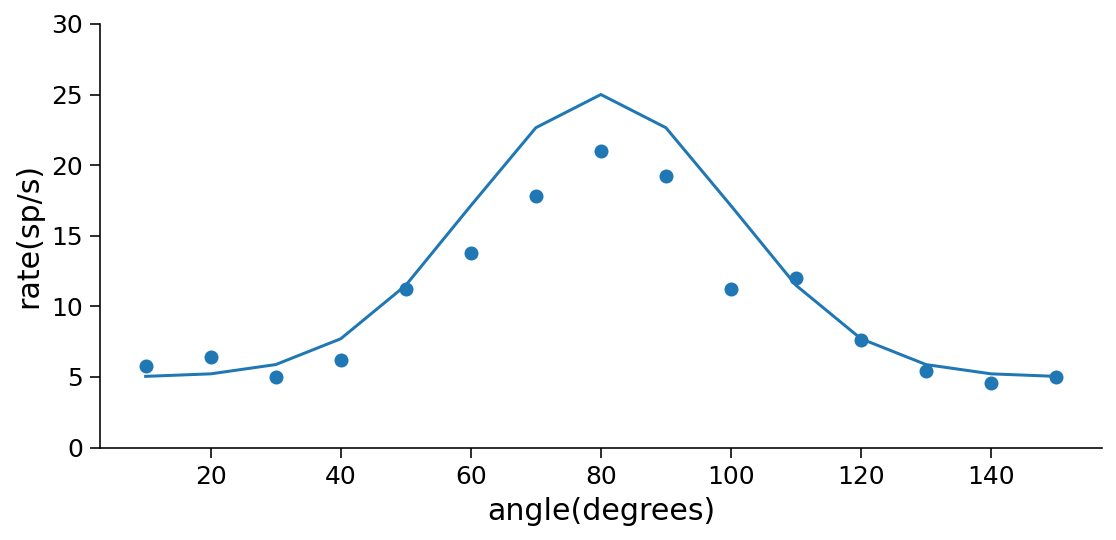

In [14]:
# calculate the mean spiking rate in spikes/s
mean_rates = np.mean(spk_mat, axis=1)*samp ### calculate the mean

fig, ax = plt.subplots(figsize=(8,4))
__ = ax.scatter(angles, mean_rates)
__ = ax.set_xlabel(f'angle(degrees)')
__ = ax.set_ylabel(f'rate(sp/s)')
__ = ax.set_ylim([0,30])

def func(size, sigma, a, b):
    return (sig.gaussian(size, sigma)*a+b)

curve = func(15, 2, 20, 5) ### adjust this gaussian to match the data

ax.plot(angles, curve)

### the poisson Process:

### $ P\left( n \right) = \frac{{ \lambda ^n }}{{n!}}e^{ - \lambda } $ , $ \lambda =  rT $ 

### Properties:
### - The probability of an event to happen is independent of previous events
### - Homogeneous Poisson process: Constant firing rate r
### - Inhomogeneous Poisson process: Time dependent firing rate r(t)

In [18]:
# generate a poisson process
samp = 100
rate = 20 / samp
duration = 50

spk_array = (np.random.uniform(size=samp*duration)<rate).astype(np.int32)

### Notice how the spike train was generated above

### We will calculate the interspike intervals and plot a histogram

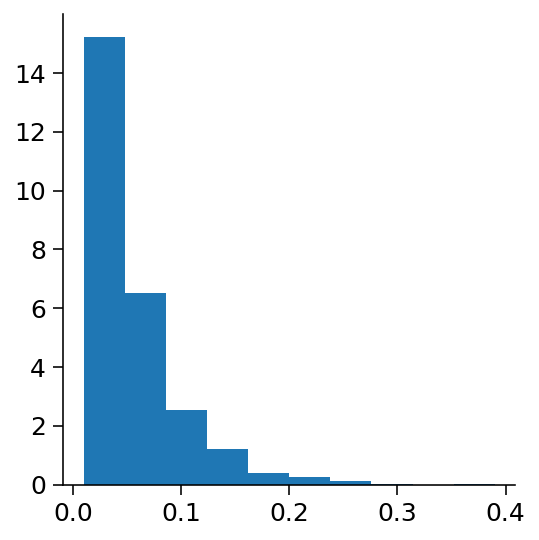

In [19]:
# translate spike times into spike times:
spk_times = np.array(np.nonzero(spk_array))/samp
# calculate interspike intervals
spk_intervals = np.diff(spk_times).reshape(-1)
# plot ISI histogram:
fig, ax = plt.subplots(figsize=(4,4))
isi_hist = ax.hist(spk_intervals,density=True)
# bin_size = 25
# bin_array = np.zeros(math.ceil(samp*duration/bin_size))
# for i, s in enumerate(np.arange(0, samp*duration, bin_size)):
#     bin_array[i] = spk_array[s:s+bin_size].sum()
isi_hist=isi_hist[0]

In [20]:
isi_hist

array([15.23545706,  6.51784259,  2.52566401,  1.19493781,  0.40736516,
        0.27157677,  0.10863071,  0.02715768,  0.        ,  0.02715768])

### For a homogeneus poisson process, the isi histogram is an exponent

### From the values of the isi histogram we can compute the coefficient of variation:

### $ C_{v}  = \frac{\sigma_{\tau}}{<\tau>} $

In [21]:
## fill in the equation in the code:

Cv = np.std(isi_hist)/np.mean(isi_hist)

print(f'the coefficient of variation for this process is {Cv}')


the coefficient of variation for this process is 1.7554567848404592


### Coefficient of variation of 1 is a necessary but not sufficient condition to identify a homogeneous Poisson process

### We can also calculate the Fano Factor (ff): the ratio between the mean and the varience of the spike count

### Complete the following code:

INFO: 2021-03-18 10:43:30,093: (T=50 ms) r=0.2 spikes/ms Mean 9.70 Var 7.59 --> Fano Factor : 0.78


(0.0, 40.0)

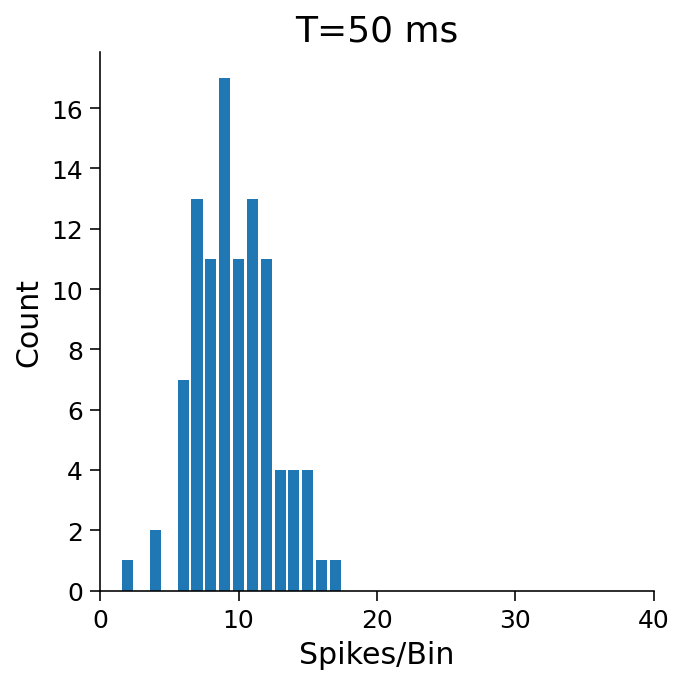

In [22]:
# select the sizes of bins we want:
bin_size = 50

# divide the signal into bins:
bin_array = np.zeros(math.ceil(samp*duration/bin_size))
for i, s in enumerate(np.arange(0, samp*duration, bin_size)):
    bin_array[i] = spk_array[s:s+bin_size].sum()
# calculate the histogram:
hist_vals, hist_bins = np.histogram(bin_array, bins = np.arange(0, bin_array.max()+2))
# calculate mean and variance:
bin_mean, bin_var = np.mean(bin_array), np.var(bin_array)
# calculate Fano Factor
ff = bin_var / bin_mean
logging.info(f'(T={bin_size} ms) r={rate} spikes/ms Mean {bin_mean:.2f} Var {bin_var:.2f} --> Fano Factor : {ff:.2f}')
# plot the histogram
fig, ax = plt.subplots(figsize=(5,5))
ax.bar(hist_bins[0:-1],hist_vals)
ax.set_xlabel('Spikes/Bin')
ax.set_ylabel('Count')
ax.set_title(f'T={bin_size} ms')
ax.set_xlim([0,40])

### Cv=1 & FF=1 are usefull tools to identify homogeneous Poisson processes but are not sufficient

In [ ]:
w